In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib widget
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
from keras import layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers.legacy import Adagrad, SGD, Adam
from keras.metrics import Precision, Recall
import cv2
import visualkeras
from PIL import ImageFont


In [2]:
def open_data(path):

    # Path to the folder where HDF5 files are saved
    input_folder = path#

    # Initialize an empty list to store image data
    image_data_list = []
    cloud_map_data_list = []

    # Set norm temperature to normalize image data
    #norm_temp = 40

    # Iterate over files in the folder
    for filename in os.listdir(input_folder):
        # Check if the file is an HDF5 file
        if filename.endswith(".h5"):
            input_path = os.path.join(input_folder, filename)

            with h5py.File(input_path, 'r') as file:
                # Check if 'image' dataset exists in the file
                if 'image' in file:
                    img_data = file['image'][:]
                    cp_data = file['label_map'][:]

                    #img_max_val = np.max((np.abs(img_data)))
                    
                    img_data = img_data#/norm_temp

                    image_data_list.append(img_data)
                    cloud_map_data_list.append(cp_data)
                else:
                    print(f"Dataset 'image' not found in file: {input_path}")

    # Convert the list of image data to a numpy array
    image_data = np.array(image_data_list)
    image_data = np.expand_dims(image_data, axis=-1)

    min_value = np.min(image_data)
    max_value = np.max(image_data)
    image_data = 2 * (image_data - min_value) / (max_value - min_value) - 1

    cloud_map_data = np.array(cloud_map_data_list)

    # Display the shape of the resulting array
    print(f"Shape of the image data array: {image_data.shape}")
    print(f"Shape of the cloud map data array: {cloud_map_data.shape}")

    return image_data, cloud_map_data

def cut_images(image_data, section_size, overlap=0.5):
    cut_frames = []

    for image in image_data:
        # Calculate the number of sections along each dimension
        num_rows = (image.shape[0] - section_size) // int(section_size * (1 - overlap)) + 1
        num_cols = (image.shape[1] - section_size) // int(section_size * (1 - overlap)) + 1

        # Cut the image into sections with 50% overlap
        for i in range(num_rows):
            for j in range(num_cols):
                row_start = i * int(section_size * (1 - overlap))
                row_end = row_start + section_size
                col_start = j * int(section_size * (1 - overlap))
                col_end = col_start + section_size

                # Append the cut section to the list
                cut_frames.append(image[row_start:row_end, col_start:col_end, :])
    
    print(f"Shape of the new data array: {(np.array(cut_frames).shape)}")

    return np.array(cut_frames)

def cut_label(image_data, section_size, overlap=0.5):
    cut_frames = []

    for image in image_data:
        # Calculate the number of sections along each dimension
        num_rows = (image.shape[0] - section_size) // int(section_size * (1 - overlap)) + 1
        num_cols = (image.shape[1] - section_size) // int(section_size * (1 - overlap)) + 1

        # Cut the image into sections with 50% overlap
        for i in range(num_rows):
            for j in range(num_cols):
                row_start = i * int(section_size * (1 - overlap))
                row_end = row_start + section_size
                col_start = j * int(section_size * (1 - overlap))
                col_end = col_start + section_size

                # Append the cut section to the list
                cut_frames.append(image[row_start:row_end, col_start:col_end, :])
    
    print(f"Shape of the new data array: {(np.array(cut_frames).shape)}")

    return np.array(cut_frames)


In [3]:
image_data, cloud_map_data = open_data('/Users/lukas/Dokumente/Uni/SSI/CNN_data/cloudfirewater/')

Shape of the image data array: (38, 320, 256, 1)
Shape of the cloud map data array: (38, 320, 256, 4)


In [4]:
def define_class_weights(cloud_map_data): 
    class_counts = np.zeros(4)
    total_counts = (cloud_map_data.size/4)//1#.shape[0]*cloud_map_data.shape[1]*cloud_map_data.shape[2]

    # Sum the values in the last dimension to get the count for each class
    class_counts = np.sum(cloud_map_data, axis=(0, 1, 2))
    class_counts_inv = total_counts/np.sum(cloud_map_data, axis=(0, 1, 2))
    class_counts_inv = (class_counts_inv/np.min(class_counts_inv)).astype(int)

    class_weights = {
        0: 1,  # no_cloud
        1: 1,  # cloud
        2: 1,  # water
        3: 10  # fire
    }

    # Display the count for each class
    for i, count in enumerate(class_counts):
        print(f"Class {i}: {int(count)}")

    print(f"Total: {int(total_counts)} pixels")

    return class_weights

In [5]:
class_weights = define_class_weights(cloud_map_data)

Class 0: 2100611
Class 1: 711263
Class 2: 300880
Class 3: 206
Total: 3112960 pixels


In [536]:
### delete fire pixels in the label data ###
# cloud_water_map_data = np.delete(cloud_map_data, 3, axis=-1)
# cloud_water_map_data.shape

(38, 320, 256, 3)

In [6]:
section_size = 128
cut_frames = cut_images(image_data, section_size=section_size, overlap=0.5)
cut_labels = cut_label(cloud_map_data, section_size=section_size, overlap=0.5)
input_shape=(section_size, section_size, 1)

Shape of the new data array: (456, 128, 128, 1)
Shape of the new data array: (456, 128, 128, 4)


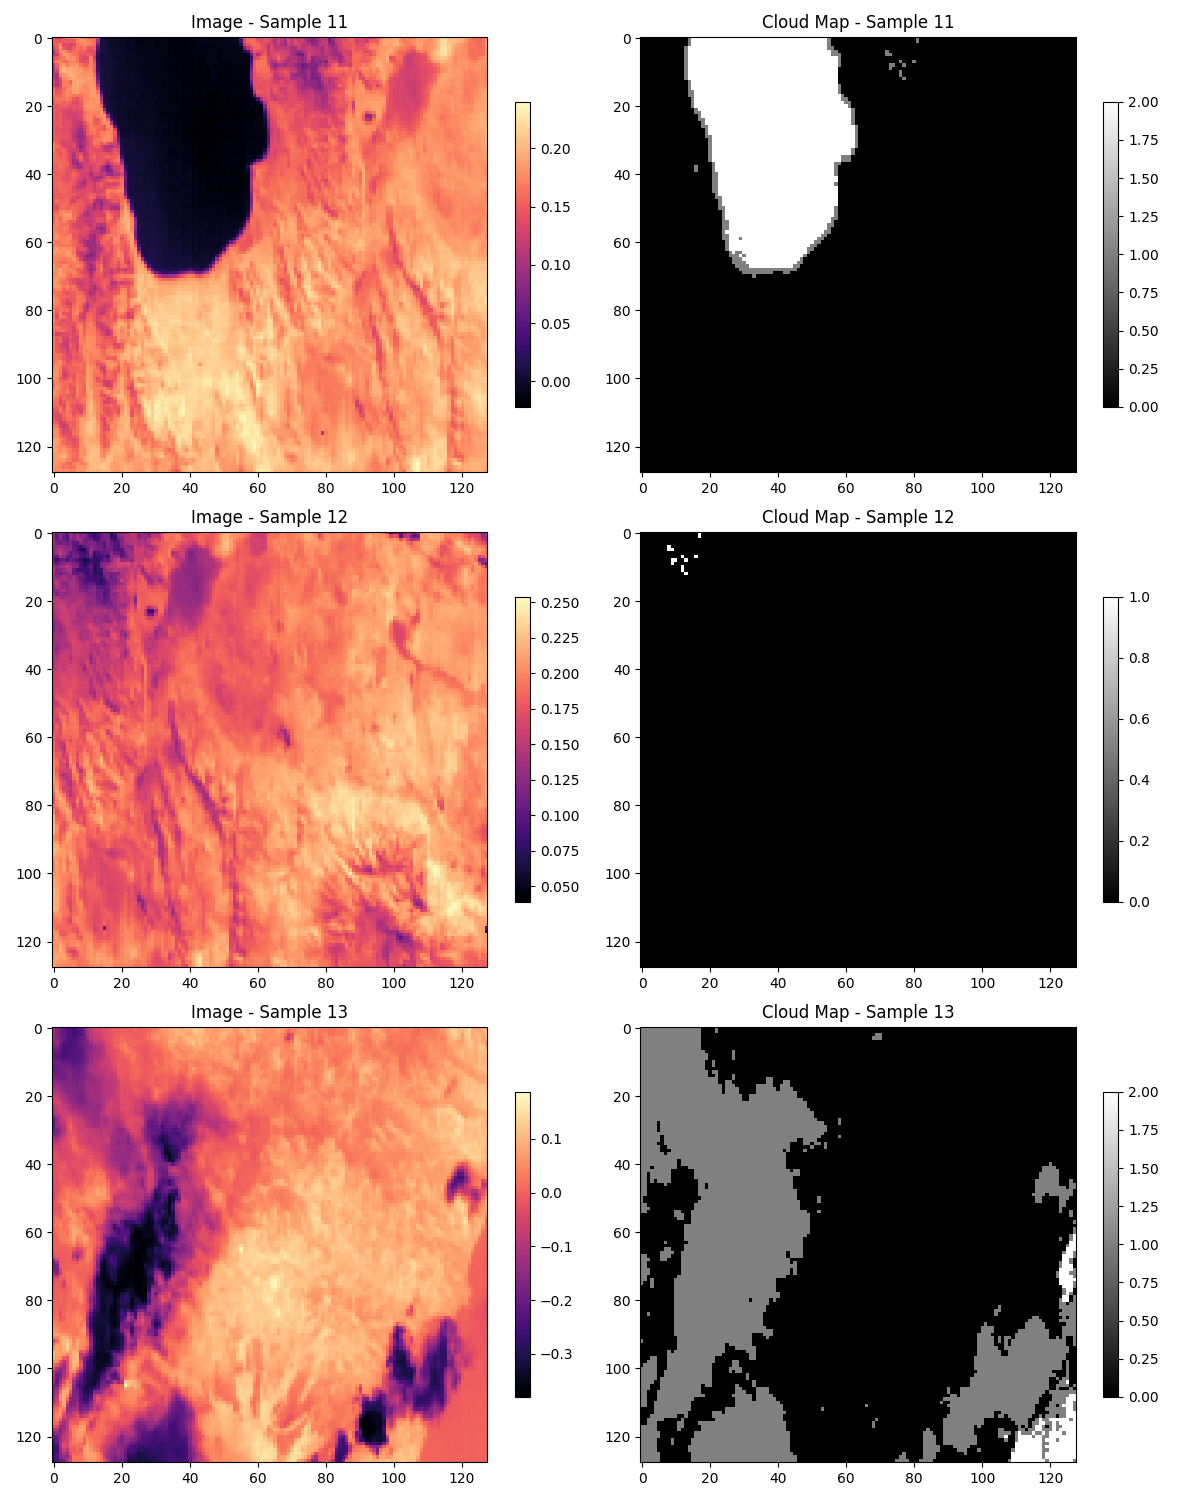

In [7]:
num_samples = 3
i_offset = 10

plt.figure(figsize=(12, 15))

# Plot the images and their corresponding cloud maps
for i in range(num_samples):
    # Plot the first image
    plt.subplot(num_samples, 2, i*2 + 1)
    plt.imshow(cut_frames[i + i_offset, :, :], cmap='magma')
    plt.title(f'Image - Sample {i + 1 + i_offset}')
    plt.colorbar(shrink=0.7)

    combined_map = np.argmax(cut_labels[i + i_offset, :, :, :], axis=-1)

    # Plot the corresponding cloud map
    plt.subplot(num_samples, 2, i*2 + 2)
    plt.imshow(combined_map, cmap='binary_r')
    plt.title(f'Cloud Map - Sample {i + 1 + i_offset}')
    plt.colorbar(shrink=0.7)

plt.tight_layout()
plt.show()

In [8]:
image_train, image_test, cloud_train, cloud_test = train_test_split(cut_frames, cut_labels, test_size=0.2, random_state=42)

In [9]:
# Encoder
inputs = layers.Input(shape=input_shape)
conv1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(inputs)
#batch1 = layers.BatchNormalization()(conv1)
conv2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(conv1)
batch2 = layers.BatchNormalization()(conv2)
pool1 = layers.MaxPooling2D((2, 2))(batch2)

conv3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool1)
batch3 = layers.BatchNormalization()(conv3)
conv4 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch3)
batch4 = layers.BatchNormalization()(conv4)
pool2 = layers.MaxPooling2D((2, 2))(batch4)

conv5 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(pool2)
batch5 = layers.BatchNormalization()(conv5)
conv6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch5)

# Decoder
up7 = layers.UpSampling2D(size=(2, 2))(conv6)
concat7 = layers.Concatenate()([up7, conv4])
batch7 = layers.BatchNormalization()(concat7)
conv7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch7)
batch8 = layers.BatchNormalization()(conv7)
conv8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch8)
dropout8 = layers.Dropout(0.025)(conv8)

up9 = layers.UpSampling2D(size=(2, 2))(dropout8)
concat9 = layers.Concatenate()([up9, conv2])
batch9 = layers.BatchNormalization()(concat9)
conv9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch9)
batch10 = layers.BatchNormalization()(conv9)
conv10 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(batch10)
dropout10 = layers.Dropout(0.05)(conv10)

# Output layer
output = layers.Conv2D(4, (1, 1), activation='softmax')(dropout10)

# Create the model
model = models.Model(inputs=inputs, outputs=output)

# Compile the model
optimizer = SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [11]:
datagen = ImageDataGenerator(
    rotation_range=45,      # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.25,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.25, # Randomly shift images vertically (fraction of total height)
    horizontal_flip=True,   # Randomly flip images horizontally
    vertical_flip=True,    # Randomly flip images vertically
    fill_mode='reflect'
)

batch_size = 15
steps_per_epoch = len(image_train) // batch_size

# Fit the data generator to the training data (assuming you have a variable named 'train_images')
datagen.fit(image_train)
gen_seed = 42

# Create a generator for both the input images and the ground truth masks
image_generator = datagen.flow(image_train, batch_size=batch_size, seed=gen_seed)
mask_generator = datagen.flow(cloud_train, batch_size=batch_size, seed=gen_seed)

# Combine the generators into one using zip
train_generator = zip(image_generator, mask_generator)

#aug_train_images = datagen.flow(image_train, cloud_train, batch_size=batch_size)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-4)


# Define a ModelCheckpoint callback to save the model at each epoch
checkpoint = ModelCheckpoint('model_epoch_{epoch:02d}.h5', save_best_only=False)


In [12]:
def plot_history(history):
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    #plt.yticks(np.arange(0.8,1.01,0.01))
    #plt.ylim(0.89,1)
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(top=1)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylim(bottom=0)
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [20]:
history = model.fit(image_train, cloud_train,
                    batch_size=batch_size, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=100, 
                    validation_data=(image_test, cloud_test)
                    )

Epoch 1/100
12/12 [==============================] - 10s 818ms/step - loss: 1.5733 - accuracy: 0.3523 - val_loss: 1.2582 - val_accuracy: 0.5827
Epoch 2/100
12/12 [==============================] - 9s 790ms/step - loss: 0.9783 - accuracy: 0.6332 - val_loss: 1.1208 - val_accuracy: 0.6567
Epoch 3/100
12/12 [==============================] - 9s 736ms/step - loss: 0.8990 - accuracy: 0.6597 - val_loss: 1.0490 - val_accuracy: 0.6708
Epoch 4/100
12/12 [==============================] - 9s 732ms/step - loss: 0.8307 - accuracy: 0.6748 - val_loss: 1.0129 - val_accuracy: 0.6968
Epoch 5/100
12/12 [==============================] - 9s 732ms/step - loss: 0.7895 - accuracy: 0.6901 - val_loss: 0.9461 - val_accuracy: 0.6982
Epoch 6/100
12/12 [==============================] - 9s 735ms/step - loss: 0.7528 - accuracy: 0.6993 - val_loss: 0.9806 - val_accuracy: 0.6459
Epoch 7/100
12/12 [==============================] - 9s 733ms/step - loss: 0.7211 - accuracy: 0.7027 - val_loss: 0.8107 - val_accuracy: 0.700

In [13]:
history = model.fit(train_generator, 
                        batch_size=batch_size, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=200, 
                        class_weight=class_weights, 
                        validation_data=(image_test, cloud_test)
                        )

Epoch 1/200
24/24 [==============================] - 20s 803ms/step - loss: 0.7710 - accuracy: 0.7021 - val_loss: 1.1575 - val_accuracy: 0.8005
Epoch 2/200
24/24 [==============================] - 18s 792ms/step - loss: 0.4919 - accuracy: 0.8291 - val_loss: 1.0434 - val_accuracy: 0.8066
Epoch 3/200
24/24 [==============================] - 18s 768ms/step - loss: 0.4326 - accuracy: 0.8505 - val_loss: 0.9557 - val_accuracy: 0.7428
Epoch 4/200
24/24 [==============================] - 18s 772ms/step - loss: 0.3917 - accuracy: 0.8631 - val_loss: 0.8418 - val_accuracy: 0.7637
Epoch 5/200
24/24 [==============================] - 18s 772ms/step - loss: 0.3878 - accuracy: 0.8597 - val_loss: 0.8116 - val_accuracy: 0.6903
Epoch 6/200
24/24 [==============================] - 19s 773ms/step - loss: 0.3951 - accuracy: 0.8555 - val_loss: 0.6487 - val_accuracy: 0.8085
Epoch 7/200
24/24 [==============================] - 18s 768ms/step - loss: 0.3580 - accuracy: 0.8759 - val_loss: 0.7917 - val_accuracy:

In [21]:
history_train = model.fit(train_generator, 
                            batch_size=batch_size, 
                            steps_per_epoch=steps_per_epoch, 
                            epochs=50, 
                            class_weight=class_weights, 
                            validation_data=(image_test, cloud_test)
                            #, callbacks=[reduce_lr]
                            )

# Append the values from history to history_main
history.history['loss'].extend(history_train.history['loss'])
history.history['val_loss'].extend(history_train.history['val_loss'])
history.history['accuracy'].extend(history_train.history['accuracy'])
history.history['val_accuracy'].extend(history_train.history['val_accuracy'])

Epoch 1/50
24/24 [==============================] - 23s 973ms/step - loss: 0.1759 - accuracy: 0.9375 - val_loss: 0.1896 - val_accuracy: 0.9248
Epoch 2/50
24/24 [==============================] - 22s 894ms/step - loss: 0.1864 - accuracy: 0.9338 - val_loss: 0.1851 - val_accuracy: 0.9277
Epoch 3/50
24/24 [==============================] - 19s 815ms/step - loss: 0.1742 - accuracy: 0.9404 - val_loss: 0.1883 - val_accuracy: 0.9226
Epoch 4/50
24/24 [==============================] - 19s 781ms/step - loss: 0.1892 - accuracy: 0.9309 - val_loss: 0.1824 - val_accuracy: 0.9276
Epoch 5/50
24/24 [==============================] - 19s 774ms/step - loss: 0.1831 - accuracy: 0.9347 - val_loss: 0.1787 - val_accuracy: 0.9284
Epoch 6/50
24/24 [==============================] - 19s 781ms/step - loss: 0.1872 - accuracy: 0.9340 - val_loss: 0.1791 - val_accuracy: 0.9283
Epoch 7/50
24/24 [==============================] - 19s 779ms/step - loss: 0.1815 - accuracy: 0.9351 - val_loss: 0.1825 - val_accuracy: 0.9268

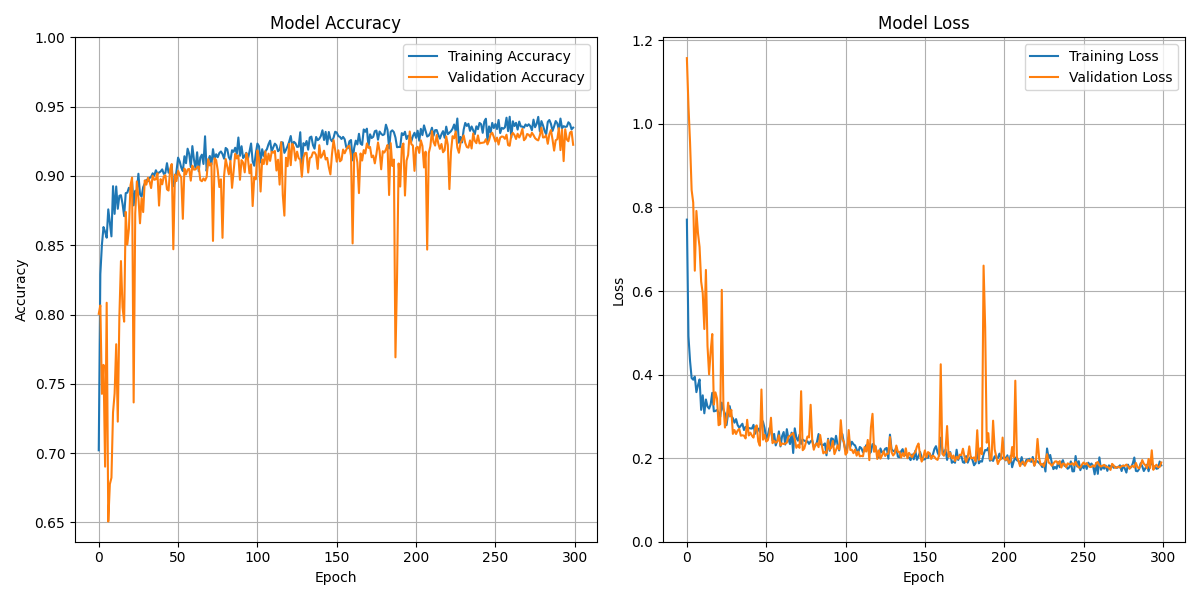

In [22]:
plot_history(history)

In [23]:
label = np.argmax(cloud_train, axis=-1)
data = image_train

#label = np.argmax(cloud_test, axis=-1)
#data = image_test

# Predict on test data
predictions = model.predict(data)

diff = np.zeros(predictions.shape)

diff = np.argmax(predictions, axis=-1) - label
# prediction_threshold = 0.5

# predictions[predictions < prediction_threshold] = 0
# predictions[predictions >= prediction_threshold] = 1

12/12 [==============================] - 5s 418ms/step


306 364


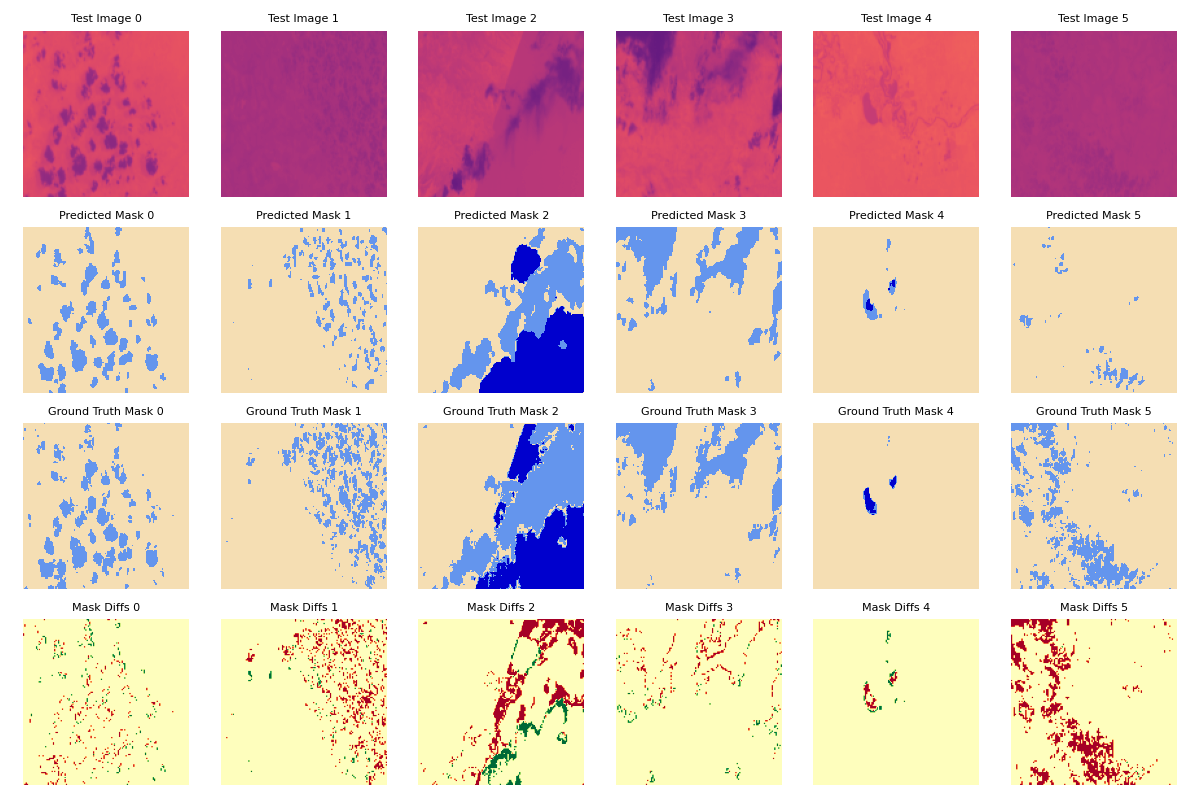

In [26]:
#label = np.argmax(cloud_test, axis=-1)
#data = image_test



cmap = mcolors.ListedColormap(['wheat', 'cornflowerblue', 'mediumblue', 'red'])



num_samples = 6

rand_offset = random.randint(0, data.shape[0]-num_samples-1)
#rand_offset = 0
print(rand_offset, data.shape[0])

# Plot a few samples  # You can change this number based on your preference

plt.figure(figsize=(12, 8))

for i in range(num_samples):
    # Original image (input)
    plt.subplot(4, num_samples, i + 1)
    plt.imshow(data[i + rand_offset, :, :], cmap='magma', vmin=-1, vmax=1)
    plt.title('Test Image ' + str(i), fontsize=8)
    plt.axis('off')

    # Predicted mask (output)
    plt.subplot(4, num_samples, i + 1 + num_samples)
    plt.imshow(np.argmax(predictions[i + rand_offset, :, :, :], axis=-1), cmap=cmap, vmin=-.5, vmax=3)
    plt.title('Predicted Mask ' + str(i), fontsize=8)
    plt.axis('off')

    # True mask
    plt.subplot(4, num_samples, i + 1 + 2 * num_samples)
    plt.imshow(label[i + rand_offset, :, :], cmap=cmap, vmin=-.5, vmax=3)
    plt.title('Ground Truth Mask ' + str(i), fontsize=8)
    plt.axis('off')



    # diff[i + rand_offset, :, :, 0] = predictions[i + rand_offset, :, :, 0]-label[i + rand_offset, :, :, 0]

    # Diff mask
    plt.subplot(4, num_samples, i + 1 + 3 * num_samples)
    plt.imshow(diff[i + rand_offset, :, :], cmap='RdYlGn', vmin=-1., vmax=1.) #RdBu''
    plt.title('Mask Diffs ' + str(i), fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

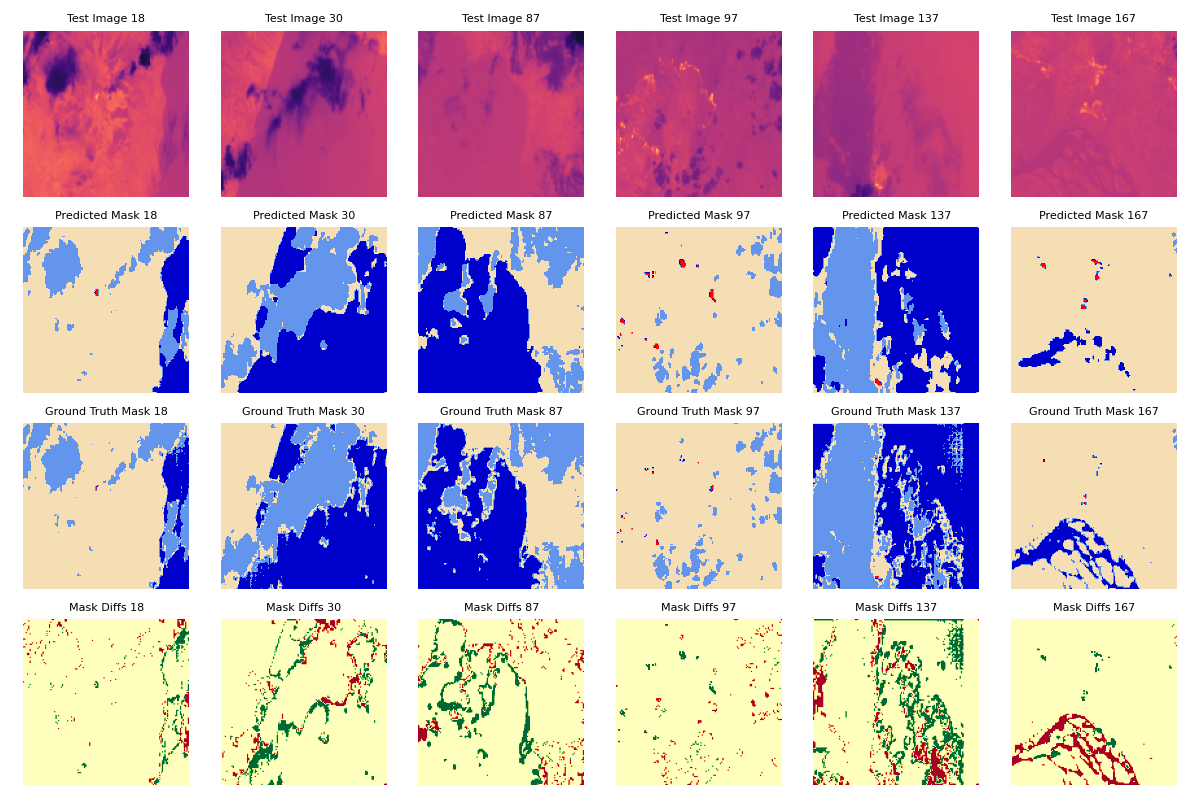

In [665]:
cmap = mcolors.ListedColormap(['wheat', 'cornflowerblue', 'mediumblue', 'red'])

# Define specific indexes to plot
indexes_to_plot = [18, 30, 87, 97, 137, 167]

# Number of samples is the length of indexes_to_plot
num_samples = len(indexes_to_plot)

plt.figure(figsize=(12, 8))

for idx, val in enumerate(indexes_to_plot):
    # Original image (input)
    plt.subplot(4, num_samples, idx + 1)
    plt.imshow(data[val, :, :], cmap='magma', vmin=-1, vmax=1)
    plt.title('Test Image ' + str(val), fontsize=8)
    plt.axis('off')

    # Predicted mask (output)
    plt.subplot(4, num_samples, idx + 1 + num_samples)
    plt.imshow(np.argmax(predictions[val, :, :, :], axis=-1), cmap=cmap, vmin=-.5, vmax=3)
    plt.title('Predicted Mask ' + str(val), fontsize=8)
    plt.axis('off')

    # True mask
    plt.subplot(4, num_samples, idx + 1 + 2 * num_samples)
    plt.imshow(label[val, :, :], cmap=cmap, vmin=-.5, vmax=3)
    plt.title('Ground Truth Mask ' + str(val), fontsize=8)
    plt.axis('off')

    # Diff mask
    plt.subplot(4, num_samples, idx + 1 + 3 * num_samples)
    plt.imshow(diff[val, :, :], cmap='RdYlGn', vmin=-1., vmax=1.)
    plt.title('Mask Diffs ' + str(val), fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [730]:
single_frames = cut_frames[3:5]
prediction_single_frame = model.predict(single_frames)

1/1 [==============================] - 0s 105ms/step


(-0.5, 127.5, 127.5, -0.5)

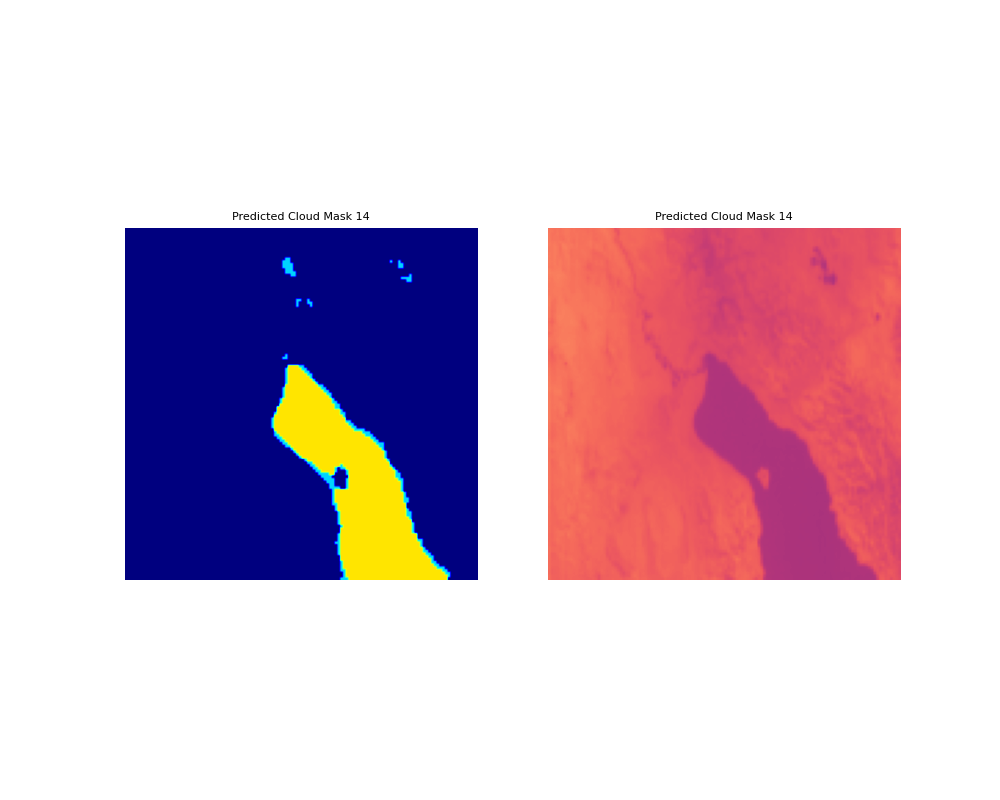

In [732]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.imshow(np.argmax(prediction_single_frame[0, :, :, :], axis=-1), cmap='jet', vmin=0.0, vmax=3)
plt.title('Predicted Cloud Mask ' + str(14), fontsize=8)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cut_frames[3], cmap='magma', vmin=-1, vmax=1)
plt.title('Predicted Cloud Mask ' + str(14), fontsize=8)
plt.axis('off')

In [692]:
model.save('best_IR_img2classmap_128x32_wc.keras')

In [29]:
model = models.load_model('best_IR_img2classmap_128x32_wc.keras')

In [73]:
def predict_classmap(path):

    input_folder = path

    model = models.load_model('best_IR_img2classmap_128x32_wc.keras')

    section_size = 128

    # Iterate over files in the folder
    for filename in os.listdir(input_folder):
        # Check if the file is an HDF5 file
        if filename.endswith(".png"):
            input_path = os.path.join(input_folder, filename)

            temp_img = cv2.imread(input_path)

            #WIP

    return

SyntaxError: incomplete input (874350364.py, line 1)